In [1]:
%load_ext autoreload
%autoreload 2

from scipy.signal import blackmanharris, gaussian
import os
import convsep.util as util
import numpy as np
import time
import matplotlib.pyplot as plt

from convsep.dataset import LargeDatasetMulti
# from trainDNN import build_ca, train_auto
from phase_transform import PhaseTransform
import keras.backend as K
import keras

# Loading the features
# Those were computed using compute_features.py
# And stored in "results/features"


# The transformation done when computing the features
tt = PhaseTransform(frameSize=2048, hopSize=512, sampleRate=44100, window=gaussian, std=10)

# db = "../DSD100_subset/""
# testdir = os.path.join(db,'Mixtures')
# transform = tt

sources = ['vocals','bass','drums','other']
n_sources = len(sources)
channels = ['left', 'right']
n_channels = len(channels)

outdir = os.path.join('results','output')
model = os.path.join('results','models',"dnn")
num_epochs = 10

Using TensorFlow backend.


In [41]:
!python compute_features.py --db ../DSD100subset/ --feature_path results/features/

  0%|                                                     | 0/2 [00:00<?, ?it/s]/home/pierre-louis/.pyenv/versions/3.5.6/lib/python3.5/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
100%|█████████████████████████████████████████████| 2/2 [00:12<00:00,  6.25s/it]


# Visualizing the data
it would be good to reduce to float32 for increasing RAM on RTX 2070

I 2019-03-19 10:05:32 dataset:1138 found 1 files
I 2019-03-19 10:05:32 dataset:1152 iteration size 21
256 2


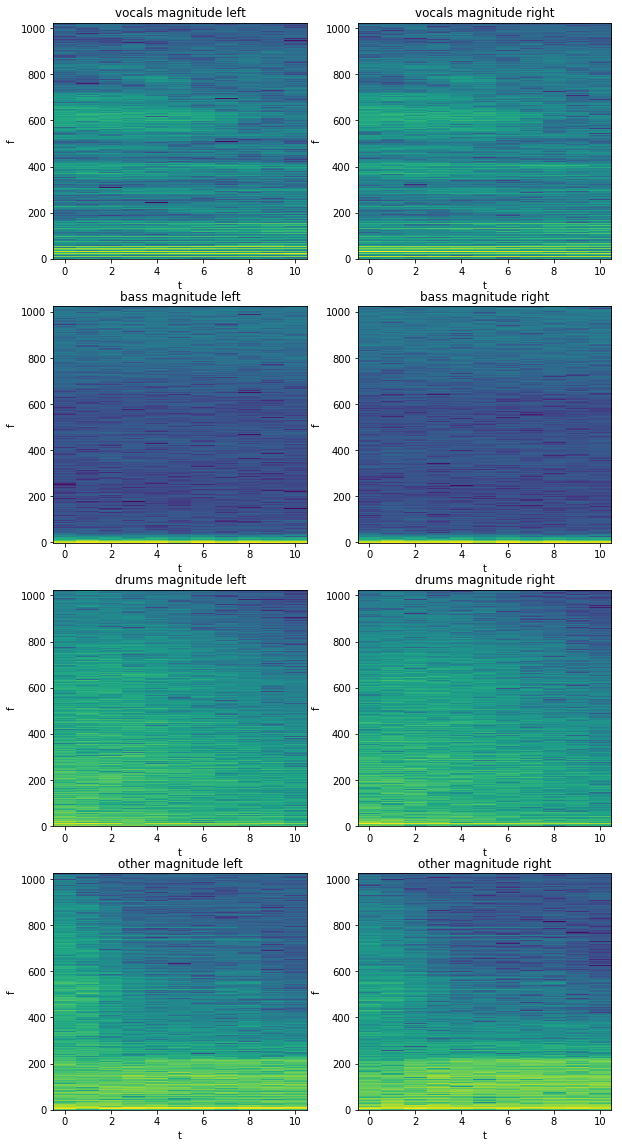

In [36]:
from convsep.dataset import LargeDatasetMulti
dataloader = LargeDatasetMulti(
                    path_transform_in="results/features/train",   
                    nsources=4, batch_size=16, batch_memory=16,
                    time_context=11, overlap=75, nprocs=4,
                    mult_factor_in=0.3, mult_factor_out=0.3,
                    extra_features=True, extra_feat_dim=3,
                    model="p")
dataloader.extra_feat_size = 1025
inputs, targets, features = dataloader()
inputs, targets, features = dataloader()
plt.figure(figsize=(5*n_channels,5*n_sources))
for i, source in enumerate(sources):
    for j, channel in enumerate(channels):
        plt.subplot(n_sources, n_channels, 1+n_channels*i+j)
        plt.imshow(np.log(1e-8+targets[0,n_channels*i+j]).T, aspect="auto",
                    origin='lower')
        plt.xlabel("t")
        plt.ylabel("f")
        plt.title(source + " magnitude " + channel)
plt.show()

# Keras model

In [31]:
features.shape

(16, 2, 11, 1025, 3)

In [17]:
from keras.layers import Dense, Concatenate, Lambda
from keras.layers import Input, Reshape, Flatten
from keras.layers import BatchNormalization as BN
from keras.models import Model
from keras.initializers import Orthogonal
from keras.utils import Sequence
from keras_tqdm import TQDMNotebookCallback
from convsep.dataset import LargeDatasetMulti
import numpy as np

def build_dnn(time_context=11, n_channels=2, freq_bins=2049, 
              n_hiddens=500):
    
    # amplitude
    ax = Input(shape=(n_channels, time_context, freq_bins),
               dtype='float32', name='amplitude')
    r_ax = Reshape((time_context*n_channels, freq_bins))(ax)
    r_ax = Lambda(lambda x: K.permute_dimensions(x,(0,2,1)))(r_ax)
    
    fc_a1 = BN()(Dense(n_hiddens,  activation="relu")(r_ax))    
    fc_a2 = BN()(Dense(n_hiddens, activation="relu")(fc_a1))

    
    # phase
    df_ph = Input(shape=(n_channels, time_context, freq_bins),
               dtype='float32', name='df_phase')
    dt_ph = Input(shape=(n_channels, time_context, freq_bins),
               dtype='float32', name='dt_phase')
    c_df = Concatenate(axis=-2)([df_ph, dt_ph])

    r_df = Reshape((time_context*n_channels*2, freq_bins))(c_df)
    r_df = Lambda(lambda x: K.permute_dimensions(x,(0,2,1)))(r_df)
    
    fc_d1 = BN()(Dense(n_hiddens, activation="relu")(r_df))
    fc_d2 = BN()(Dense(n_hiddens, activation="relu")(fc_d1))
    
    
    # regression
    c_all = Concatenate(axis=-1)([fc_a2, fc_d2])
    
    fc_r1 = BN()(Dense(2, activation="relu")(c_all))
    fc_r1 = Lambda(lambda x: K.permute_dimensions(x,(0,2,1)))(fc_r1)
    
    model = Model(inputs=[ax, df_ph, dt_ph], outputs=fc_r1)
    model.compile(optimizer="adam", loss="mse")
    return model


class DataGenerator(Sequence):
    """ Conversion of a LargeDataset class into a Keras Sequence """
    
    def __init__(self, features_path, batch_size=16, time_context=11, 
                 n_channels=2, freq_bins=2049, n_sources=4, 
                 shuffle=True, source_id=0):
        'Initialization'
        self.dataloader = LargeDatasetMulti(
            path_transform_in=features_path, overlap=75,
            nsources=n_sources, batch_size=batch_size,
            batch_memory=batch_size, time_context=time_context,
            nprocs=1, mult_factor_in=0.3, mult_factor_out=0.3,
            tensortype='float32', extra_features=True, 
            extra_feat_dim=3, model="p")
        self.dataloader.extra_feat_size = (freq_bins-1)//2 + 1
        self.n_points = self.dataloader.total_points
        self.time_context = time_context
        self.batch_size = batch_size
        self.freq_bins = freq_bins
        self.n_channels = n_channels
        self.n_sources = n_sources
        self.source_id = source_id
        self.shuffle = shuffle

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.n_points / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        mag, targets, features = self.dataloader()
        ph, df_ph, dt_ph = features[..., 0], features[..., 1], features[..., 2]
        y = targets[:, self.source_id:self.source_id+self.n_channels, 0, :]
        return {'amplitude': mag, 
                'df_phase': df_ph, 
                'dt_phase': dt_ph}, y
    
traingen = DataGenerator("results/features/train")
validgen = DataGenerator("results/features/valid")

drum_dnn = build_dnn(freq_bins=1025)
# drum_dnn.summary()  

I 2019-03-19 11:36:12 dataset:1137 found 2 files
I 2019-03-19 11:36:12 dataset:1151 iteration size 42
256 3 float32 1025
I 2019-03-19 11:36:12 dataset:1137 found 2 files
I 2019-03-19 11:36:13 dataset:1151 iteration size 42
256 3 float32 1025


In [18]:
from keras_tqdm import TQDMNotebookCallback
from convsep.dataset import LargeDatasetMulti
# dataloader = LargeDatasetMulti(
#                     path_transform_in="results/features/train",   
#                     nsources=4, batch_size=16, batch_memory=16,
#                     time_context=11, overlap=75, nprocs=4,
#                     mult_factor_in=0.3, mult_factor_out=0.3,
#                     extra_features=True, extra_feat_dim=3,
#                     model="p")
# dataloader.extra_feat_size = 1025
# drum_dnn = build_dnn(freq_bins=1025)

# for i in range(100):
# mag, targets, features = traingen.dataloader()
# ph, df_ph, dt_ph = features[..., 0], features[..., 1], features[..., 2]
# y = targets[:,:2,5,:]
# print(y.shape)
# print(ph.shape, df_ph.shape, dt_ph.shape, y)

# out = drum_dnn.train_on_batch([mag, df_ph, dt_ph], y)
# drum_dnn.train_on_batch([mag, df_ph, dt_ph], y)
#     out_2 = drum_dnn.predict(x)
    
history = drum_dnn.fit_generator(traingen, validation_data=validgen, verbose=False,
               epochs=10, use_multiprocessing=False, callbacks=[TQDMNotebookCallback()])

Epoch 1/10


41/42 [============================>.] - ETA: 0s - loss: 0.947485 3 float32 1025
171 3 float32 1025
170 3 float32 1025
42/42 [==============================] - 4s 105ms/step - loss: 0.9463 - val_loss: 3.1459
Epoch 2/10


41/42 [============================>.] - ETA: 0s - loss: 0.8638256 3 float32 1025
85 3 float32 1025
171 3 float32 1025
42/42 [==============================] - 3s 67ms/step - loss: 0.8604 - val_loss: 2.2537
Epoch 3/10


19/42 [============>.................] - ETA: 0s - loss: 0.4597

KeyboardInterrupt: 

In [10]:
print(y.shape)

(16, 2, 11, 1025)


In [33]:
targets.shape

(16, 8, 11, 1025)

In [22]:
print(out.shape)

(16, 2, 1025)


In [50]:
from convsep.dataset import LargeDatasetMulti

dataloader = LargeDatasetMulti(
                    path_transform_in="results/features/train",   
                    nsources=4, batch_size=16, batch_memory=16,
                    time_context=11, overlap=75, nprocs=1,
                    mult_factor_in=0.3, mult_factor_out=0.3,
                    extra_features=True, extra_feat_dim=3,
                    model="p")
for i in range(300):
#     try
    mag, targets, features = dataloader()

I 2019-03-19 11:27:33 dataset:1136 found 2 files
I 2019-03-19 11:27:33 dataset:1150 iteration size 42


In [18]:
mag, targets, features = dataloader()
ph, df_ph, dt_ph = features[..., 0], features[..., 1], features[..., 2]